# Exercises day 01

In [95]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy
import collections
from helper_functions import plot_hist_and_corr, chungus_test

### Testing Neumanns simple method

In [96]:
def neumann_four_digit(seed : int, break_point : int = None) -> tuple[list[float], list[int], list[int]]:
    """
        A function that generates a sequence of random numbers using the Neumann four digit method.
        
        :param seed: The seed for the Neumann generator.
        :param break_point: The number of iterations to run the generator for.
        
        :return: A tuple containing the sequence of random numbers, the sequence of x values, and the sequence of x^2 values.
    """
    
    if break_point is None:
        break_point = 10**6 # 1 million
    
    assert type(break_point) is int, "break_point must be an integer!"
    
    U = []
    xs = []
    xsquareds = []
    x = seed
    counter = 0
    while counter < break_point and x > 0:
        U.append(x / 10**4)
        xs.append(x)
        xsquareds.append(x ** 2)
        x = ((x ** 2) // 10**2) % 10**4
        counter += 1
    
    return U, xs, xsquareds

U, xs, xsquareds = neumann_four_digit(7182, 30)

print(f"U = \n{U}\n")
print(f"xs = \n{xs}\n")
print(f"xsquareds = \n{xsquareds}\n")

U = 
[0.7182, 0.5811, 0.7677, 0.9363, 0.6657, 0.3156, 0.9603, 0.2176, 0.7349, 0.0078, 0.006, 0.0036, 0.0012, 0.0001]

xs = 
[7182, 5811, 7677, 9363, 6657, 3156, 9603, 2176, 7349, 78, 60, 36, 12, 1]

xsquareds = 
[51581124, 33767721, 58936329, 87665769, 44315649, 9960336, 92217609, 4734976, 54007801, 6084, 3600, 1296, 144, 1]



This was technically not an exercise, however we implemented it just for fun (because it was quick), and it definitely shows just how prone this methods is to terminating as a couple of leading zeroes will cripple it completely.

*(A naïve fix might be to just add $1000$ if ever the generated number is below $1000$. We didn't test this however, and instead focused on our LCG.)*

## Ex. 1

Implement a Linear Congruental Generator

In [97]:
def linear_congruental_generator(multiplier : int, shift : int, modulus: int, x0 : int = None, break_point : int = None) -> tuple[list[int], list[float]]:
    """
        Generates a list of random numbers using the linear congruental generator method.
        
        NOTE: random_nums and U will have length 'modulus' if the parameters follows the conditions
        of Theorem 1 Maximum Cycle Length.

        :param multiplier: The multiplier (a) used in the formula.
        :param shift: The shift (c) used in the formula.
        :param modulus: The modulus (M) used in the formula.
        :param x0: initial value (x0) used in the formula. If not provided, a random value will be used.
        
        :return random_nums: a list of randomly generated numbers.
        :return U: a list of random numbers between 0 and 1.
    """
    
    assert type(modulus) is int, "Modulus must be an integer."
    assert modulus > 0, "Modulus must be greater than 0."
    
    if x0 is None:
        x0 = np.random.randint(0, modulus)
    
    if break_point is None:
        break_point = (modulus // 10)
        
    random_nums = [x0]
    U = [x0 / modulus]
    random_nums_generated = 0
    while random_nums_generated < modulus and random_nums_generated < break_point:
        random_nums.append((multiplier * random_nums[-1] + shift) % modulus) 
        U.append(random_nums[-1] / modulus)
        random_nums_generated += 1
    
    return random_nums, U


Testing whether the Linear Congruental Generator works as presented in the slides

In [98]:
M = 16
a = 5
c = 1
x0 = 3

ranom_nums, U = linear_congruental_generator(multiplier=a, shift=c, modulus=M, x0=x0)

print(f"Random numbers: \n{ranom_nums}\n")
print(f"U: \n{U}\n")

Random numbers: 
[3, 0]

U: 
[0.1875, 0.0]



### Histogram

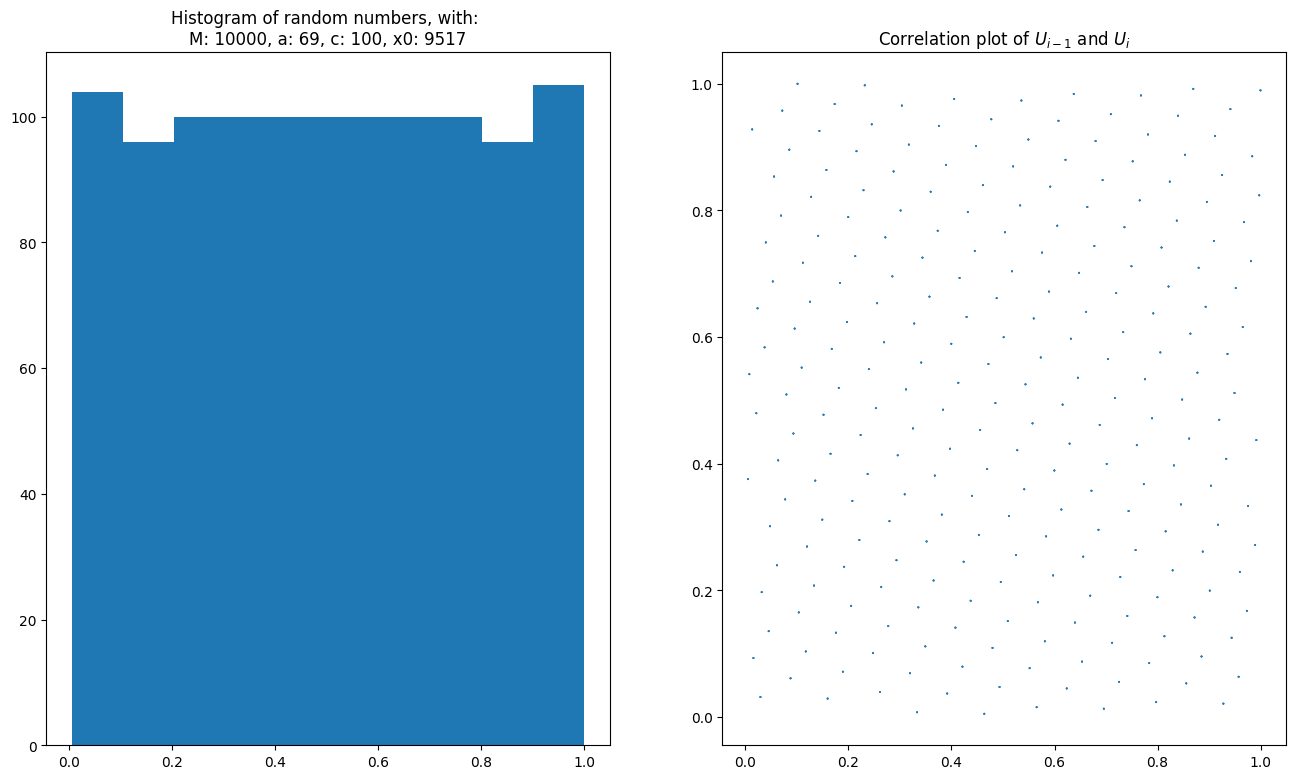

In [99]:
M_hist = 10**4
multiplier_hist = 69
shift_hist = 100
x0_hist = 420

plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = None, num_bins = None, num_scatter_points = 1000)


Very clearly not randomly dsitributed points.

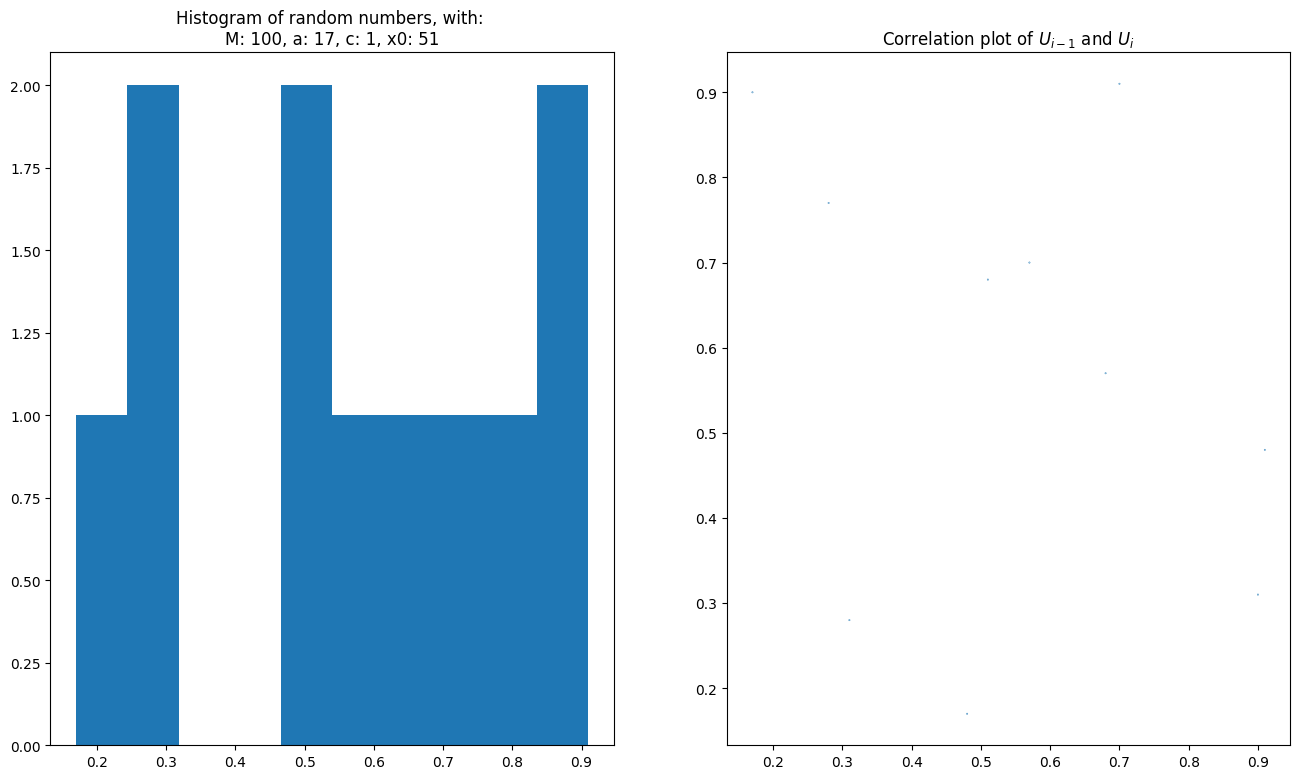

In [100]:
M_hist = 100
multiplier_hist = 17
shift_hist = 1
x0_hist = 69

plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = None, num_bins = None, num_scatter_points = None)

There are not really enough points here to draw any real conclusions.

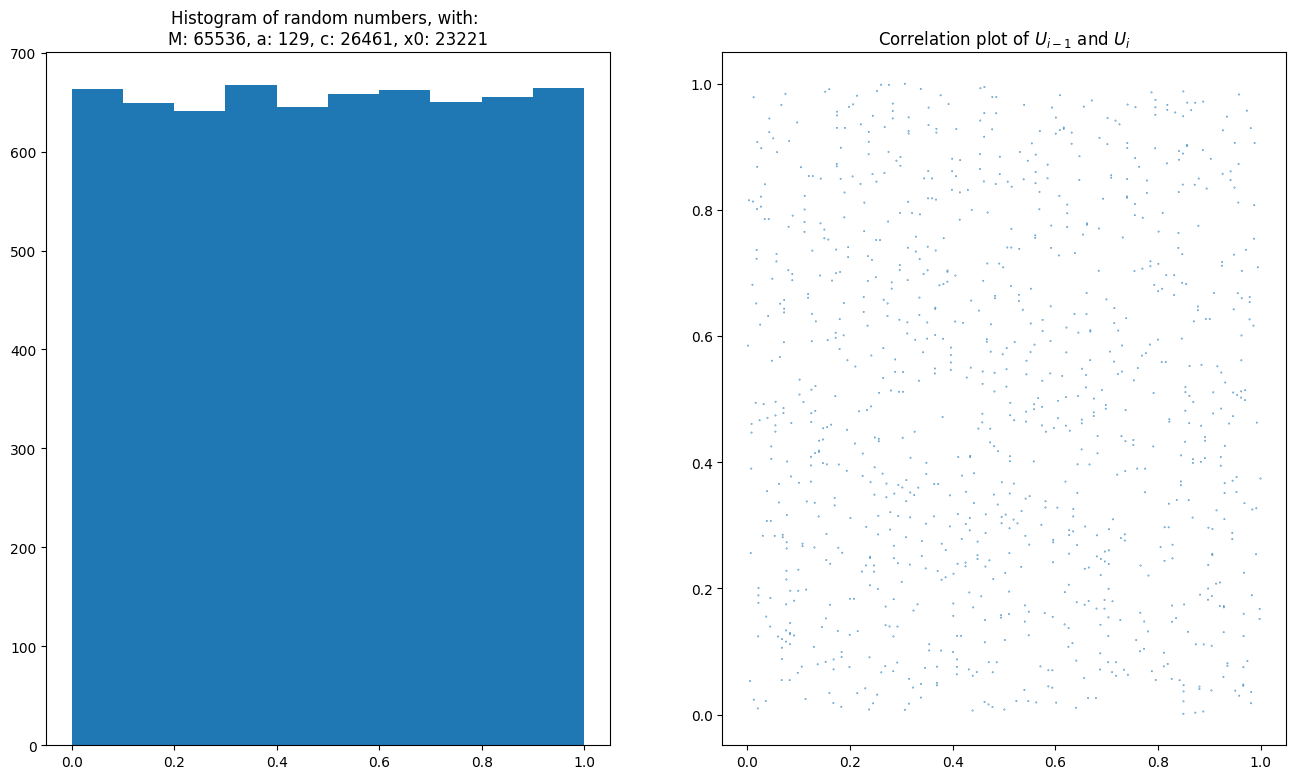

In [101]:
M_hist = 65536
multiplier_hist = 129
shift_hist = 26461
x0_hist = 420

plot_hist_and_corr(multiplier = multiplier_hist, shift =shift_hist, modulus = M_hist, x0 = None, num_bins = None, num_scatter_points = 1000)

Now this looks randomly distributed, because it is so well scattered. In all fairness this is also the values as given on slides.

### Test (distribution tests)
The $\chi$-test

In [102]:
def chi_squared_test_U(U : list[float], num_bins : int) -> float:
    """
        This function performs the chi-squared test on a list of random numbers.
        For uniform expected distribution.
        
        :param U: list of random numbers (uniformly distributed).
        :param num_bins: number of bins to divide the random numbers into.
        
        :return p: returns the p-value of the test.
    """
    
    N = len(U)
    expected_num_in_bins = N / num_bins
    
    # Divied into bins
    counts, _ = np.histogram(U, bins=num_bins)

    T = np.sum((counts - expected_num_in_bins)**2 / expected_num_in_bins)

    df = num_bins -1 -1 # when number of estimated parameters is m=1
    
    p = 1 - scipy.stats.chi2.cdf(T, df)
    
    return p

Kolmogorov-Smirnov $O(n \cdot \log(n))$

In [103]:
def kolmogorov_smirnov_unif(data_points : list[float], modulus : int) -> float:
    """
        Implementation of the Kolmogorov-Smirnov test-statistic in O(n * log(n)).
        Tests whether the sampled data_points are uniformly distributed.
        NOTE: could be expanded to be given two CDFs (F_0, F_T) and then just
        find the maximum distance between the two (this fitted our case better).
        
        :param data_points: the sampled, uniformly distributed data points
        :param modulus: the highest possible value in the sampled data points (parameter for LCG)
        
        :return: the Kolmogorov-Smirnov test-statistic 
    """
    # number of data-points
    num_samples = len(data_points)
    
    F_0 = np.sort(data_points) / modulus
    F_T = np.linspace(0, 1, num_samples)
    test_statistic = np.abs(F_0 - F_T).max()
    
    return test_statistic
    

### Run-tests (correlation tests)

#### Up-and-Down test

In [104]:
def up_and_down_test(random_nums : list[float]):
    """
        The up and down test is a test for randomness. It counts the number of runs in a sequence of random numbers.
        A run is defined as a sequence of consecutive numbers that are either increasing or decreasing.
        (See slide 20 on 'slide2bm1.pdf' for more info).
        
        :param random_nums: a list of random numbers.
        
        :return Z: the test statistic (I think).
    """
    R = []
    
    n = len(random_nums)
    
    previous = None
    run_length = 0
    for i in range(len(random_nums) - 1):
        if random_nums[i] < random_nums[i + 1]:
            if previous == "up" or previous is None:
                run_length += 1
                previous = "up"
            elif previous == "down":
                R.append(run_length)
                run_length = 1
                previous = "up"
        else:
            if previous == "down" or previous is None:
                run_length += 1
                previous = "down"
            elif previous == "up":
                R.append(run_length)
                run_length = 1
                previous = "down"
                
    count = collections.Counter(R)
    
    for key, val in count.items():
        expected_val = 0
        if key == 1:
            expected_val = (n + 1)/ 12
        elif key == 2:
            expected_val = (11*n -4) / 12
        else:
            expected_val = (2 * ((key**2 + 3*key + 1)*n - (key**3 + 3*key**2 - key - 4)) ) / np.math.factorial(key + 3)
        
        print(f"Expected number of runs of length: {key} is: {np.round(expected_val, 2):>10}")
        print(f"The actual length is: {np.round(val, 2):>26}.00\n") # <-- this is some scummy code and won't exrapolate to all cases.
    
    X = len(R)
    Z = (X - (2 * n - 1) / 3) / np.sqrt( ((16 * n - 29) / 90) ) 
    
    return Z
    

#### Above/Below


In [105]:
def above_below(random_nums : list[float], median : float) -> tuple[list[int], list[int], int, int, float, float]:
    """
        Calculates the runs for the Above/Below test, as given in the first lecture.
        (See slide 17, on 'slide2bm1.pdf').
        NOTE: This is made for for a sample of uniformly distributed random numbers.
        (So this distribution should have a theoretical median).
        NOTE: The test statistic for this test is given as R_a + R_b.
        
        :param random_nums: a list of random numbers.
        :param median: the expected median of the random numbers.
        
        :return R_a: a list of runs of numbers above the median.
        :return R_b: a list of runs of numbers below the median.
        :return n_1: the total number of numbers above the median.
        :return n_2: the total number of numbers below the median.
        :return mu: the expected value of the test statistic.
        :return sigma: the standard deviation of the test statistic.
    """
    
    R_a = []
    R_b = []
    
    previous = None
    run_length = 0
    for random_num in random_nums:
        if random_num < median:
            if previous == "below" or previous is None:
                run_length += 1
                previous = "below"
            elif previous == "above":
                R_b.append(run_length)
                run_length = 1
                previous = "below"
        elif random_num > median:
            if previous == "above" or previous is None:
                run_length += 1
                previous = "above"
            elif previous == "below":
                R_a.append(run_length)
                run_length = 1
                previous = "above"
    
    n_1 = sum(R_a)
    n_2 = sum(R_b)
    
    mu = 2 * (n_1 * n_2) / (n_1 + n_2) + 1
    sigma = 2 * (n_1 * n_2 * (2 * n_1 * n_2 - n_1 - n_2)) / ((n_1 + n_2)**2 + (n_1 + n_2 - 1))
    
    return R_a, R_b, n_1, n_2, mu, sigma
              

#### Up/Down

In [106]:
def up_down(random_nums : list[float]) -> float:
    """
        Knuth's Up/Down test, as given in the first lecture.
        (See slide 18, on 'slide2bm1.pdf').
        
        :param random_nums: a list of random numbers between 0 and 1.
        
        :return Z: a list (of something I don't know yet).
    """

    n = len(random_nums)
    
    # This is a little confusing and maybe not the best code. We index R, such that index
    # 0 corresponds to a run of length 1, index 1 corresponds to a run of length 2, etc.
    R = np.zeros(6)
    run_length = 1
    for i in range(len(random_nums) - 1):
        if random_nums[i] < random_nums[i + 1]:
            run_length += 1
        else:
            run_length = min(run_length, 6)
            R[run_length - 1] += 1
            
            run_length = 1
    
    R = R.reshape(-1, 1) # <-- importent because otherwise (R - n * B) gives a matrix (and we don't want that, no, no).

    A = np.array([
        [4529.4, 9044.9, 13568, 18091, 22615, 27892],
        [9044.9, 18097, 27139, 36187, 45234, 55789],
        [13568, 27139, 40721, 54281, 67852, 83685],
        [18091, 36187, 54281, 72414, 90470, 111580],
        [22615, 45234, 67852, 90470, 113262, 139476],
        [27892, 55789, 83685, 111580, 139476, 172860]
        ])

    B = np.array([
        [1/6],
        [5/24],
        [11/120],
        [19/720],
        [29/5040],
        [1/840]
        ])
    
    Z = (1 / (n - 6)) * (R - n * B).T @ A @ (R - n * B)
    
    return Z.item()



##### 
Testing Up / Down with Bo's example

In [107]:
bo_test = [0.54, 0.67, 0.13, 0.69, 0.33, 0.45, 0.90, 0.01, 0.45, 0.76, 0.82, 0.24, 0.17]

n = len(bo_test)
    
# This is a little confusing and maybe not the best code. We index R, such that index
# 0 corresponds to a run of length 1, index 1 corresponds to a run of length 2, etc.
R = np.zeros(6)
run_length = 1
for i in range(len(bo_test) - 1):
    if bo_test[i] < bo_test[i + 1]:
        run_length += 1
    else:
        run_length = min(run_length, 6)
        R[run_length - 1] += 1
        
        run_length = 1

R = R.reshape(-1, 1) # <-- important because otherwise (R - n * B) gives a matrix (and we don't want that, no, no).

print(R)

[[1.]
 [2.]
 [1.]
 [1.]
 [0.]
 [0.]]


### Actually running the tests

#### Good values

6554 random numbers generated using the Linear Congruental Generator with parameters:
Multiplier (a): 129
shift (c): 26461
modulus (M): 65536
Initial value (x0): 35635

Multiple tests were performed: 

>>>> FIRSTLY from the distribution tests <<<<
From the Chi-squared test for 10 bins:
The test statistic T = 0.9850330588170257 
should be asymptotically chi-squared with 8 degrees of freedom.
We test that by p-value. The p-value is: 0.9983411813566669.
With a significance level of: 0.05 we find that the test is significant.

From the Kolmogorov-Smirnov test:
The test-statistic: 0.9999847447033972, 
should be asymptotically K-S distributed.
We test that by p-value. The p-value is: 0.7299839750702265
With a significance level of: 0.05 we find that the test is significant.


>>>> SECONDLY from the correlation tests <<<<
From the Up-and-Down test we find: 
Expected number of runs of length: 2 is:     6007.5
The actual length is:                       1189.00

Expected number of runs of lengt

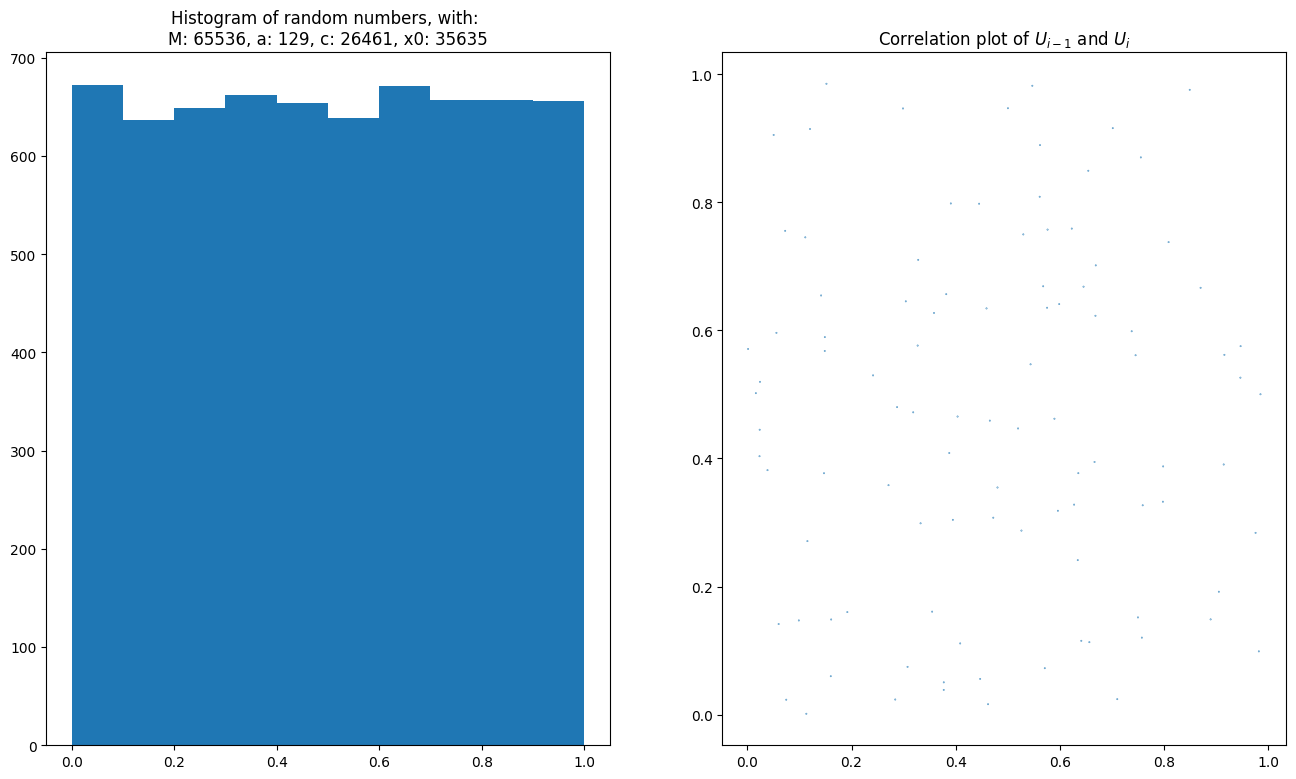

In [108]:
M = 65536
multiplier = 129
shift = 26461
x0 = 35635

chungus_test(multiplier = multiplier, shift =shift, modulus = M, x0 = x0, plot = True, num_scatter_points=10**4)

Here we test with some values provided by Bo on his slides. We see that none of them fail the null-hypothesis. And that scatter plot looks somewhat randomly distributed. Although the histram isn't a perfect box, this is the kind of deviation that is to be expected.

#### Less good values

1001 random numbers generated using the Linear Congruental Generator with parameters:
Multiplier (a): 69
shift (c): 100
modulus (M): 10000
Initial value (x0): 420

Multiple tests were performed: 

>>>> FIRSTLY from the distribution tests <<<<
From the Chi-squared test for 10 bins:
The test statistic T = 0.9999999999830433 
should be asymptotically chi-squared with 8 degrees of freedom.
We test that by p-value. The p-value is: 0.9982483774438163.
With a significance level of: 0.05 we find that the test is significant.

From the Kolmogorov-Smirnov test:
The test-statistic: 0.9999012, 
should be asymptotically K-S distributed.
We test that by p-value. The p-value is: 0.7298944047376519
With a significance level of: 0.05 we find that the test is significant.


>>>> SECONDLY from the correlation tests <<<<
From the Up-and-Down test we find: 
Expected number of runs of length: 1 is:       83.5
The actual length is:                        409.00

Expected number of runs of length: 2 is:     9

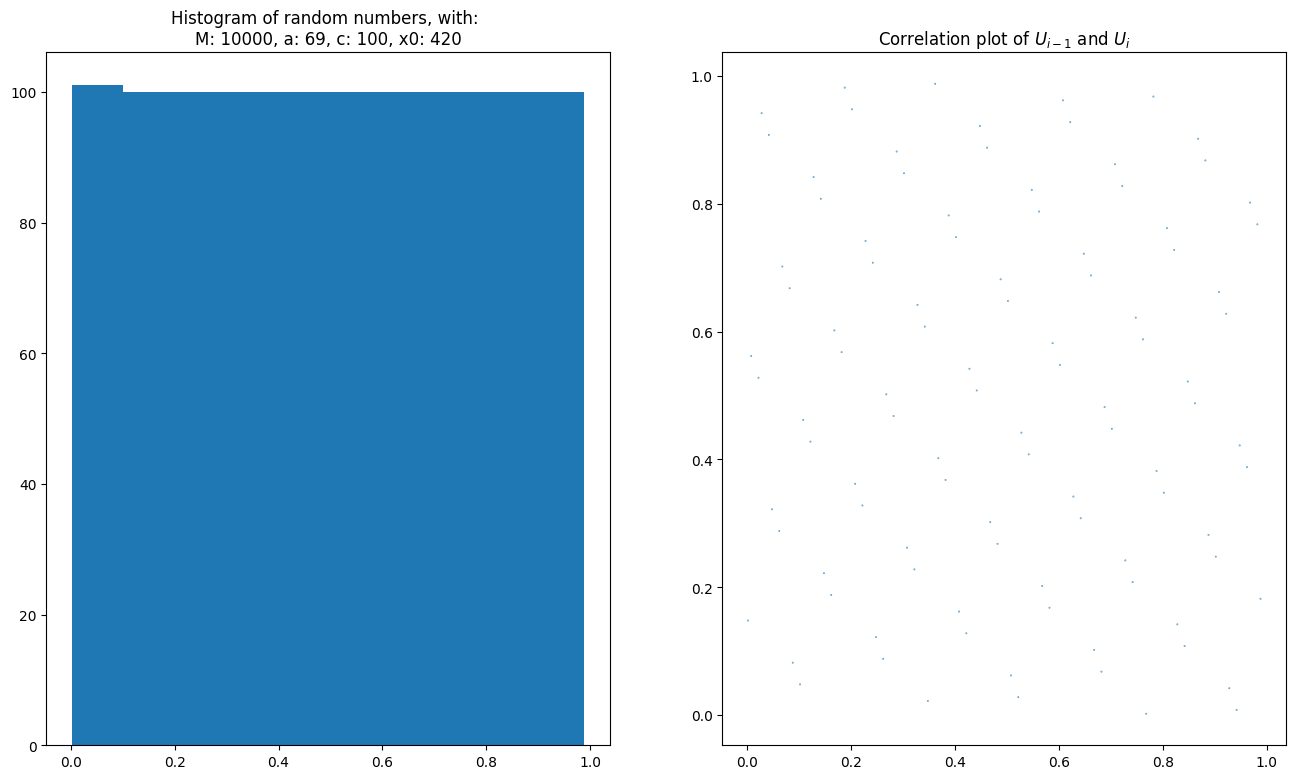

In [109]:
M = 10**4
a = 69
c = 100
x0 = 420

chungus_test(multiplier = a, shift =c, modulus = M, x0 = x0, plot = True)

As previously discussed, these particular parameter picks for the the Linear Congruental Generator yields poorly distributed values. However, it is extremely interesting to note, that although the scatter-(correlation)-plot clearly shows that these points aren't randomly, uniformly distributed, it parses all distribution- as well as correlation tests. This goes to show that neither the analytical nor visual test can be employed without the other.

#### Simply testing

16976 random numbers generated using the Linear Congruental Generator with parameters:
Multiplier (a): 227
shift (c): 37854
modulus (M): 169758
Initial value (x0): 128309

Multiple tests were performed: 

>>>> FIRSTLY from the distribution tests <<<<
From the Chi-squared test for 10 bins:
The test statistic T = 0.9838773381433193 
should be asymptotically chi-squared with 8 degrees of freedom.
We test that by p-value. The p-value is: 0.9983482023388475.
With a significance level of: 0.05 we find that the test is significant.

From the Kolmogorov-Smirnov test:
The test-statistic: 0.9999941105453488, 
should be asymptotically K-S distributed.
We test that by p-value. The p-value is: 0.7299940150766842
With a significance level of: 0.05 we find that the test is significant.


>>>> SECONDLY from the correlation tests <<<<
From the Up-and-Down test we find: 
Expected number of runs of length: 1 is:    1414.75
The actual length is:                       7088.00

Expected number of runs of le

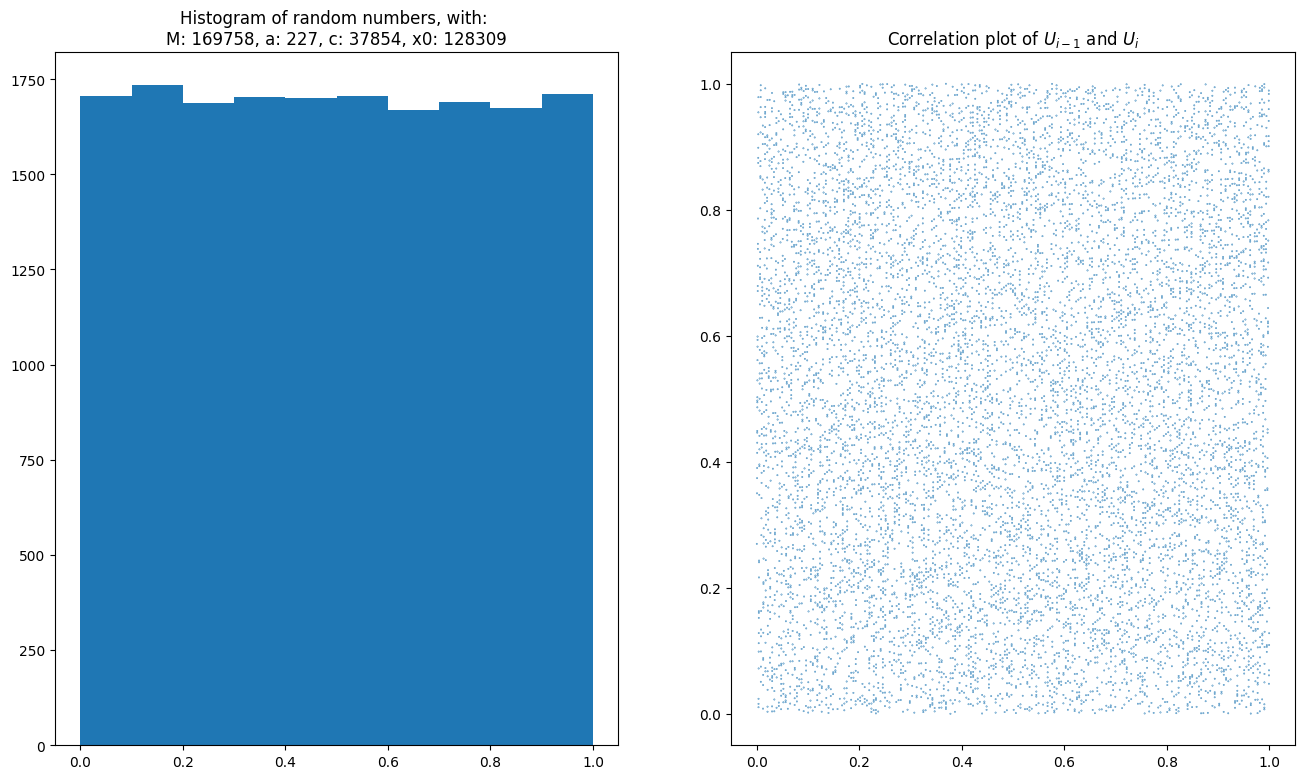

In [110]:
M = 169758
multiplier = 227
shift = 37854
x0 = 128309

chungus_test(multiplier = multiplier, shift =shift, modulus = M, x0 = x0, plot = True, num_scatter_points=10**4)

These are just some nice values that we wanted to include because the look gooood! :D

## Testing '*system available*' generator

100000 random numbers provided.
Will now test for uniformity.

Multiple tests were performed: 

>>>> FIRSTLY from the distribution tests <<<<
From the Chi-squared test for 10 bins:
The test statistic T = 0.7578753594166459 
should be asymptotically chi-squared with 8 degrees of freedom.
We test that by p-value. The p-value is: 0.9993642986017223.
With a significance level of: 0.05 we find that the test is significant.

From the Kolmogorov-Smirnov test:
The test-statistic: 0.9999900000923578, 
should be asymptotically K-S distributed.
We test that by p-value. The p-value is: 0.7299896087817141
With a significance level of: 0.05 we find that the test is significant.


>>>> SECONDLY from the correlation tests <<<<
From the Up-and-Down test we find: 
Expected number of runs of length: 1 is:    8333.42
The actual length is:                      41711.00

Expected number of runs of length: 2 is:   91666.33
The actual length is:                      18299.00

Expected number of runs of length

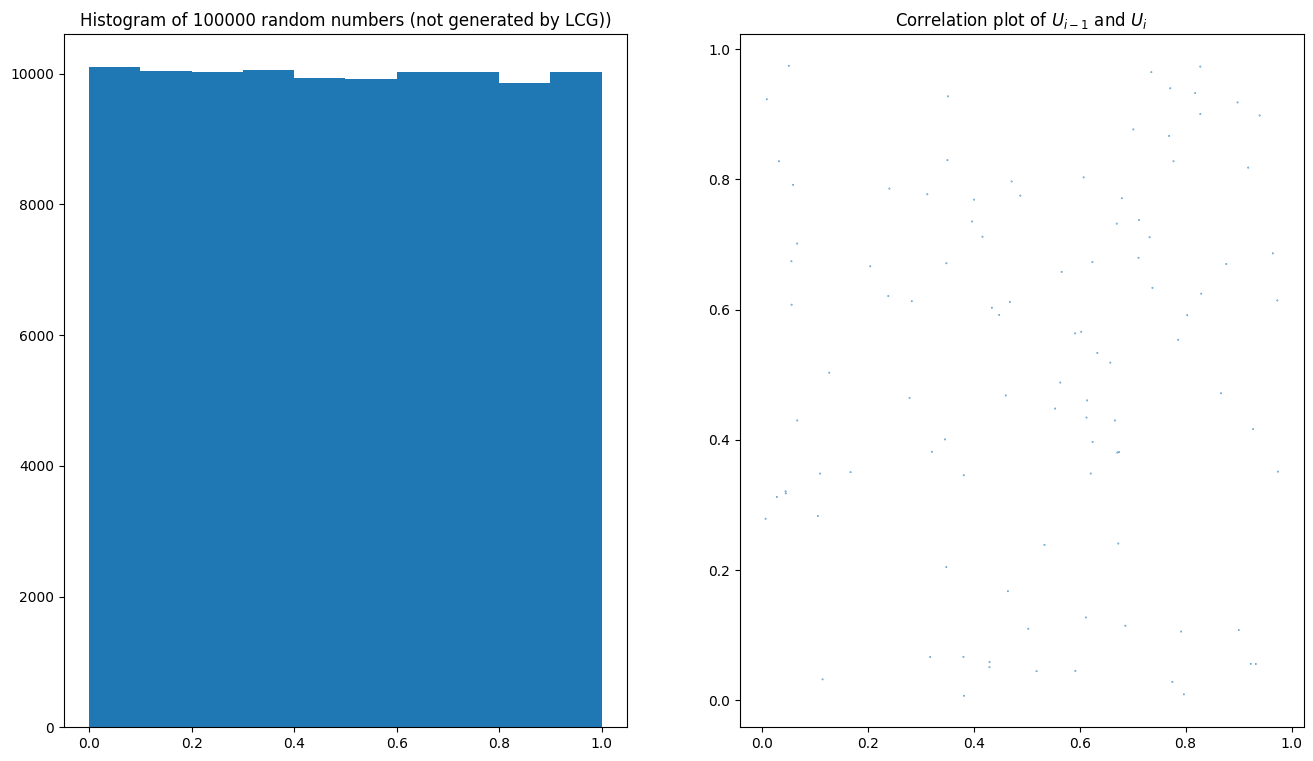

In [111]:
U = np.random.uniform(0, 1, 10**5)
chungus_test(U=U, plot=True)

The values generated with `numpy`'s `random` library are (*suprise*) very good.

## Testing uniformity of p-values for $Chi^2$ and Kolmogorov-Smirnov

In [112]:
import os

name_chi_ps = "naive_chi_ps"
name_ks_ps = "naive_ks_ps"
if not os.path.exists(name_chi_ps + ".npy") and not os.path.exists(name_chi_ps + ".npy"):
    M = 65536
    multiplier = 129
    shift = 26461
    x0 = 35635

    chi_squared_bins = 10


    modulus_vals = [(i + 49)**2 for i in range(1, 25)]
    multiplier_vals = [i + 1 for i in range(1, 25)]
    shift_vals = [i*10 + 1 for i in range(1, 25)]

    chi_ps = []
    ks_ps = []
    for modulus in modulus_vals:
        for multiplier in multiplier_vals:
            for shift in shift_vals:
                _, U = linear_congruental_generator(multiplier=multiplier, shift=shift, modulus=M, x0=1)
                
                T = chi_squared_test_U(U, chi_squared_bins)
                df = chi_squared_bins -1 -1 # when number of estimated parameters is m=1
                p_chi_sqr = 1 - scipy.stats.chi2.cdf(T, df)
                chi_ps.append(p_chi_sqr)
                
                D_n = kolmogorov_smirnov_unif(U, M)
                p_KS = 1 - scipy.special.kolmogorov(D_n)
                ks_ps.append(p_KS)
    
    np.save(name_chi_ps + "01.npy", chi_ps)
    np.save(name_ks_ps + "01.npy", ks_ps)
    
    try:
        unique_chi_ps = np.unique(np.load(name_chi_ps + ".npy"))
        unique_ks_ps = np.unique(np.load(name_ks_ps + ".npy"))
    except:
        unique_chi_ps = np.unique(np.load(name_chi_ps + "01.npy"))
        unique_ks_ps = np.unique(np.load(name_ks_ps + "01.npy"))
        
    print(f"There are {len(unique_chi_ps)} p-vals from chi-squared: \n{unique_chi_ps}")
    print(f"There are {len(unique_ks_ps)} p-vals from Kolmogorov-Smirnov: \n{unique_ks_ps}")

In [113]:
chi_ps = np.load(name_chi_ps + ".npy")
ks_ps = np.load(name_ks_ps + ".npy")
unique_chi_ps = np.unique(chi_ps)
unique_ks_ps = np.unique(ks_ps)
print(f"There are {len(unique_chi_ps)} p-vals from chi-squared: \n{unique_chi_ps[:5]}")
print(f"There are {len(unique_ks_ps)} p-vals from Kolmogorov-Smirnov: \n{unique_ks_ps[:280:56]}")

There are 6 p-vals from chi-squared: 
[0.99824838 0.99824838 0.99824838 0.99824838 0.99824838]
There are 285 p-vals from Kolmogorov-Smirnov: 
[0.72998397 0.72998414 0.72998486 0.72998629 0.72998833]


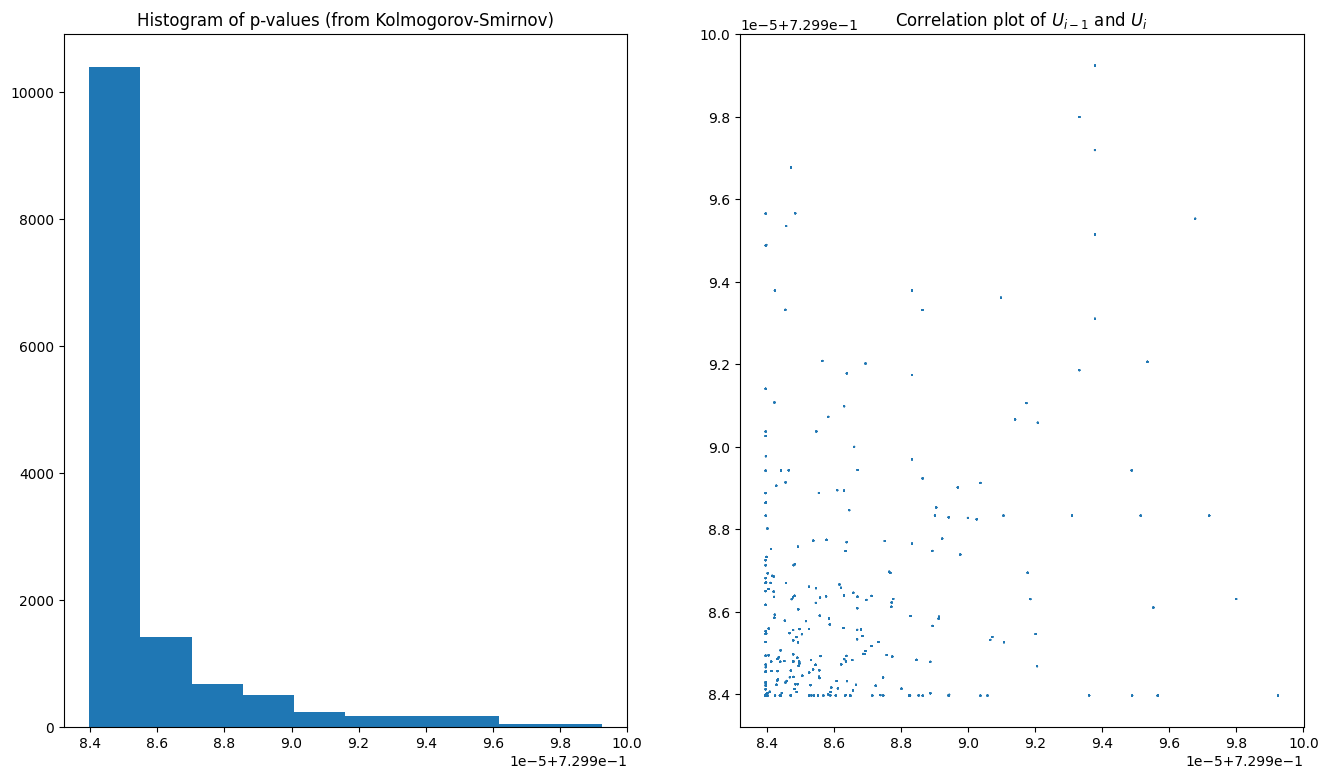

In [114]:
num_scatter_points = 10**4

plt.figure(figsize=(16, 9))
plt.subplot(1,2,1)
plt.title(f"Histogram of p-values (from Kolmogorov-Smirnov)")
plt.hist(ks_ps, bins=10)

plt.subplot(1, 2, 2)
plt.title("Correlation plot of $U_{i - 1}$ and $U_i$")
plt.scatter(ks_ps[:num_scatter_points], ks_ps[1:(num_scatter_points + 1)], s=[0.1]*num_scatter_points)

plt.show()